In [14]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.io as pio
from pathlib import Path


pio.renderers.default = "browser"
# pd.options.plotting.backend = 'plotly'

This is a data science project about League of Legends for the class DSC 80 at UCSD. 

Names: Joyce Hu and Ellie Wang

# Introduction

For our project, we are interested in exploring dataset about the game League of Legends from Oracle's Elixir. As League of Legends continues to constantly update the game, there are changes to all aspects that we want to investigate. More specifically, we aim to answer qusetions about the champion Neeko.

# Data Cleaning and Exploratory Data Analysis

For our project, we worked with smaller dataframes taken from `league`, which is the dataframe that concats together League of Legends datasets from Oracle's Elixir from the years 2021, 2022, 2023, and 2024. To appropriately clean the data, we:

- created `patch_missing`: a new column that holds a binary variable for missing patches 
- imputed missing patches by mapping specific dates to corresponding patch versions
- imputed team statistics; team-level statistics for certain variables (`firstdragon`, `firstherald`, `heralds`, `opp_heralds`) are imputed into missing player-level stats by extracting team summary stats from the dataset and merging them with player-level data based on `gameid` and `teamid`
- created `post_rework`: binary variable for patch rework; checks if patch is greater than or equal to 13.09 
- created `neeko`: binary variable to indicate whether Neeko played n the game 
- created `herald_diff`: represents the difference in number of heralds gained by the team and the opponent team 
- kept the features we need for the rest of the project 


We cleaned the dataset this way to make the data more compatible to  answer our question: is there a higher proportion of games with a Neeko in it after the Patch 13.9 rework? 



In [60]:
fp1 = '../data/league_2021.csv'
fp2 = '../data/league_2022.csv'
fp3 = '../data/league_2023.csv'
fp4 = '../data/league_2024.csv'

leeg21 = pd.read_csv(fp1)
leeg22 = pd.read_csv(fp2)
leeg23 = pd.read_csv(fp3)
leeg24 = pd.read_csv(fp4)

league = pd.concat([leeg21, leeg22, leeg23, leeg24])
league.head()

/Users/elliekwang/miniforge3/envs/dsc80/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: DtypeWarning:

Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.



,gameid,datacompleteness,url,league,year,split,playoffs,date,game,patch,...,opp_csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15
0,ESPORTSTMNT03/1632489,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,2021,NaN,0,2021-01-02 07:40:39,1.0,10.25,...,118.0,748.0,-56.0,-4.0,2.0,0.0,1.0,0.0,1.0,1.0
1,ESPORTSTMNT03/1632489,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,2021,NaN,0,2021-01-02 07:40:39,1.0,10.25,...,84.0,2120.0,3405.0,62.0,3.0,2.0,0.0,2.0,0.0,3.0
2,ESPORTSTMNT03/1632489,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,2021,NaN,0,2021-01-02 07:40:39,1.0,10.25,...,143.0,1578.0,354.0,15.0,2.0,3.0,0.0,0.0,0.0,0.0
3,ESPORTSTMNT03/1632489,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,2021,NaN,0,2021-01-02 07:40:39,1.0,10.25,...,120.0,124.0,102.0,10.0,0.0,4.0,2.0,1.0,1.0,2.0
4,ESPORTSTMNT03/1632489,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,2021,NaN,0,2021-01-02 07:40:39,1.0,10.25,...,25.0,448.0,450.0,3.0,1.0,4.0,0.0,0.0,2.0,2.0


In [61]:
# make copy 
pre_cleaning = league.copy()

# binary variable for missing patch
league['patch_missing'] = (league['patch'].isna()).astype(int)

## impute missing patches
patches = {
    '2022-08-11 08:37:33':12.15, 
    '2022-08-12 06:08:39':12.15, 
    '2022-08-12 07:04:40':12.15, 
    '2022-08-12 07:52:33':12.15, 
    '2022-08-12 08:51:49':12.15, 
    '2022-08-12 09:58:13':12.15, 
    '2022-08-13 06:08:31':12.15, 
    '2022-08-13 06:55:35':12.15, 
    '2022-08-13 06:08:31':12.15,
    '2022-08-13 06:55:35':12.15,
    '2022-08-13 07:47:42':12.15,
    '2023-04-05 09:17:28':13.07,
    '2023-04-05 10:18:03':13.07, 
    '2023-04-05 11:23:10':13.07,
    '2023-04-05 12:21:13':13.07,
    '2023-04-05 13:10:18':13.07,
    '2023-05-08 06:12:19':13.09,
    '2023-05-08 07:07:13':13.09,
    '2023-05-08 08:12:21':13.09,
    '2023-05-08 09:06:19':13.09,
    '2023-05-08 10:08:36':13.09,
    '2024-02-21 06:02:57':14.03,
    '2024-02-21 06:56:52':14.03, 
    '2024-02-21 07:43:27':14.03,
    '2024-02-21 08:31:33':14.03, 
    '2024-02-21 09:17:02':14.03
}
league['patch'] = league['patch'].fillna(league['date'])
league['patch'] = league['patch'].replace(patches)

## impute team statistics into missing player level stats for 'firstdragon', 'firstherald', 'heralds', 'opp_heralds'

# get team summary statistics 
team_stats = (league[(league['participantid'] == 100) | (league['participantid'] == 200)]
              .loc[:,['gameid', 'teamid','firstdragon', 'firstherald', 'heralds', 'opp_heralds']])

# subset dataframe to player level data
league = league[(league['participantid'] != 100) & (league['participantid'] != 200)]

# drop stats cols in league to retain col names after merge
league = league.drop(columns=['firstdragon', 'firstherald', 'heralds', 'opp_heralds'])

# merge team stats onto player level data
league = league.merge(team_stats, on=['gameid', 'teamid'], how='left')

# create a binary variable for before and after Patch 13.9
league['post_rework'] = (league['patch'] >= 13.09).astype(int)

# create a binary variable for whether neeko played in the game
league['neeko'] = (league['champion'] == 'Neeko').astype(int)

# create a new variable for difference in heralds gained 
league['herald_diff'] = league['heralds'] - league['opp_heralds']

# keep features we need
league = (league.loc[:, ['gameid', 'teamid', 'neeko', 'position', 'datacompleteness','league', 
                'patch', 'patch_missing','firstdragon', 'firstherald', 'herald_diff', 'goldat15','xpat15','csat15',
                'golddiffat15','xpdiffat15','csdiffat15','killsat15','assistsat15','deathsat15',
                'result']])

league.head()

,gameid,teamid,neeko,position,datacompleteness,league,patch,patch_missing,firstdragon,firstherald,...,goldat15,xpat15,csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,result
0,ESPORTSTMNT03/1632489,oe:team:2e79800a550f87f2378dbba9368396d,0,top,complete,KeSPA,10.25,0,1.0,1.0,...,5407.0,7536.0,114.0,748.0,-56.0,-4.0,2.0,0.0,1.0,1
1,ESPORTSTMNT03/1632489,oe:team:2e79800a550f87f2378dbba9368396d,0,jng,complete,KeSPA,10.25,0,1.0,1.0,...,6974.0,8232.0,146.0,2120.0,3405.0,62.0,3.0,2.0,0.0,1
2,ESPORTSTMNT03/1632489,oe:team:2e79800a550f87f2378dbba9368396d,0,mid,complete,KeSPA,10.25,0,1.0,1.0,...,6591.0,7827.0,158.0,1578.0,354.0,15.0,2.0,3.0,0.0,1
3,ESPORTSTMNT03/1632489,oe:team:2e79800a550f87f2378dbba9368396d,0,bot,complete,KeSPA,10.25,0,1.0,1.0,...,5202.0,5053.0,130.0,124.0,102.0,10.0,0.0,4.0,2.0,1
4,ESPORTSTMNT03/1632489,oe:team:2e79800a550f87f2378dbba9368396d,0,sup,complete,KeSPA,10.25,0,1.0,1.0,...,3853.0,4681.0,28.0,448.0,450.0,3.0,1.0,4.0,0.0,1


In [62]:
# print(league.head().to_markdown(index = False))

## Univariate Analysis

## Bivariate Analysis

## Interesting Aggregates

This is a pivot table of the number of games with neeko from patch 12.10 to 14.05, seperated by the position she was played in. It is interesting because we can see the amount of games she was played in increases over time. 

In [63]:
# just looking at patch 12.10 - present
recent = league[league['patch'] >= 12.10]

recent_pv = (recent.pivot_table(index='patch', columns='position', values='neeko', aggfunc='sum', 
                    margins=True, margins_name='total'))

# print(recent_pv.to_markdown())
# recent.pivot_table

In [64]:
league['patch_missing']

0         0
1         0
2         0
3         0
4         0
         ..
382785    0
382786    0
382787    0
382788    0
382789    0
Name: patch_missing, Length: 382790, dtype: int64

# Assessment of Missingness

## NMAR Analysis

We do not belive that there is a column in our dataset that is NMAR. While there are a lot of columns with missing data, we believe that most are related to the column `datacompletedness`. 

Additionally, based on our preliminary findings when looking at the "patch" column that has missing data, we believe that the column "league", which is composed of the different leagues played in the game, could explain the missingness since we found that there were only missing patches for two leagues out of the 56.

## Missingness Dependency: `patch`

A column that is important to our hypothesis test is the `patch` column. However, we found that the `patch` column had **382840** missing values. We analyzed its relationship with the `league` and `result` columns to check its missingness dependency. 

### 1. `patch` v. `league`


In [88]:
piv = league.pivot_table(index='league', columns='patch_missing', aggfunc='size').fillna(0)
piv = piv / piv.sum()
obs1 = piv.diff(axis=1).iloc[:,-1].abs().sum() / 2
print(obs1)
piv.head()

0.8440988106129917


patch_missing,0,1
league,,
AL,0.005777,0.0
AOL,0.000967,0.0
BIG,0.003869,0.0
BL,0.002692,0.0
BM,0.002300,0.0


In [89]:
n_repetitions = 500
shuffled = league.loc[:,['league', 'patch_missing']]

tvds = []
for _ in range(n_repetitions):
    
    # shuffle whether patch is missing
    shuffled['shuffle_patch'] = np.random.permutation(shuffled['patch_missing'])
    
    # Computing and storing the TVD.
    pivoted = (
        shuffled.pivot_table
        (index='league', columns='shuffle_patch', aggfunc='size').fillna(0)
    )
    
    pivoted = pivoted / pivoted.sum()
    
    tvd = pivoted.diff(axis=1).iloc[:, -1].abs().sum() / 2
    tvds.append(tvd)
tvds[:10]

[0.17026183941097023,
 0.20190334596784734,
 0.1946130135494271,
 0.21275138326144732,
 0.19381235568335292,
 0.20839955561364526,
 0.21043806909772145,
 0.21987757591600227,
 0.19031324881279138,
 0.17501916960745872]

#### p-value: 

In [90]:
(np.array(tvds) >= obs1).mean()

0.0

In [97]:
fig1 = px.histogram(pd.DataFrame(tvds), x=0, nbins=50, histnorm='probability', 
                   title='Empirical Distribution of the TVD (patch v. league)')
fig1.add_vline(x=obs1, line_color='red')
fig1.add_annotation(text=f'<span style="color:red">Observed TVD = {round(obs1, 2)}</span>',
                   x=1 * obs1, showarrow=False, y=0.16)
fig1.update_layout(yaxis_range=[0, 0.2])
fig.write_html

<bound method BaseFigure.write_html of Figure({
    'data': [{'alignmentgroup': 'True',
              'bingroup': 'x',
              'histnorm': 'probability',
              'hovertemplate': '0=%{x}<br>probability=%{y}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': '',
              'nbinsx': 50,
              'offsetgroup': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'histogram',
              'x': array([0.00848233, 0.02515946, 0.00819479, ..., 0.01265161, 0.04154903,
                          0.02487191]),
              'xaxis': 'x',
              'yaxis': 'y'}],
    'layout': {'annotations': [{'showarrow': False,
                                'text': '<span style="color:red">Observed TVD = 0.0</span>',
                                'x': 0.00033067572866293246,
                                'y': 0.16}],
               'barmode': 'r

In [99]:
fig.write_html('patch1.html', include_plotlyjs='cdn')

**Conclusion:**
- Since our p-value = 0.0 which is less than our alpha value of 0.5, we conclude that the missingness of `patch` **does** depend on `league`.

### 2. `patch` v. `result`

In [94]:
piv = league.pivot_table(index='result', columns='patch_missing', aggfunc='size').fillna(0)
piv = piv / piv.sum()
obs2 = piv.diff(axis=1).iloc[:,-1].abs().sum() / 2

print(obs2)
piv

0.00014377205594040543


patch_missing,0,1
result,,
0,0.500144,0.5
1,0.499856,0.5


In [95]:
n_repetitions = 500
shuffled = league.loc[:,['result', 'patch_missing']]

tvds = []
for _ in range(n_repetitions):
    
    # shuffle whether patch is missing
    shuffled['shuffle_patch'] = np.random.permutation(shuffled['patch_missing'])
    
    # Computing and storing the TVD.
    pivoted = (
        shuffled.pivot_table
        (index='result', columns='shuffle_patch', aggfunc='size').fillna(0)
    )
    
    pivoted = pivoted / pivoted.sum()
    
    tvd = pivoted.diff(axis=1).iloc[:, -1].abs().sum() / 2
    tvds.append(tvd)
tvds[:10]

[0.004313052759987807,
 0.004313052759987807,
 0.01682089487213001,
 0.033210473576438804,
 0.008194789352154397,
 0.012651614168082609,
 0.024871912168344057,
 0.00848233346403518,
 0.00848233346403518,
 0.04600585980046179]

**p-value:**

In [86]:
(np.array(tvds) >= obs2).mean()

1.0

In [96]:
fig_2 = px.histogram(pd.DataFrame(tvds), x=0, nbins=50, histnorm='probability', 
                   title='Empirical Distribution of the TVD (patch v. result)')
fig_2.add_vline(x=obs2, line_color='red')
fig_2.add_annotation(text=f'<span style="color:red">Observed TVD = {round(obs2, 2)}</span>',
                   x=2.3 * obs2, showarrow=False, y=0.16)
fig_2.update_layout(yaxis_range=[0, 0.2])

**Conclusion:**
Since our p-value = 1.0 which is greater than our alpha level of 0.05, we can conclude that the missingness of `patch` **does not** depend on the `result` column. 

AttributeError: 'Rectangle' object has no property 'barmode'

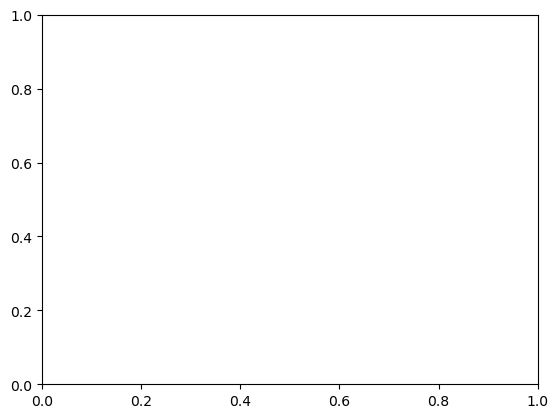

In [75]:
piv.plot(kind='barh', title='Gender by Missingness of Child Height (MAR Example)', barmode='group')
piv
